## Project Overview

- **Objective**: Forecast short-horizon product demand per `time_series_id`.
- **Data**: `simplified_cayzn_train.parquet` for train/val and `simplified_cayzn_test.parquet` for hold-out testing.
- **Preprocessing**: Log transformation (log10(1+x)) applied to demand and price to handle skewed distributions.
- **Model**: LSTM encoder-decoder predicting a multi-step demand horizon.
- **Metrics**: Optimize MSE in log10 space, report MAE in original scale for interpretability.
- **Artifacts**: Best weights stored at `best_lstm_forecaster.pt`, with evaluation plots below.



In [992]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_parquet("simplified_cayzn_train.parquet")
df_test=pd.read_parquet("simplified_cayzn_test.parquet")



I wanted to do some plots which are correlation matrix and plotting the demand and price to see what kind of distributions they will have.

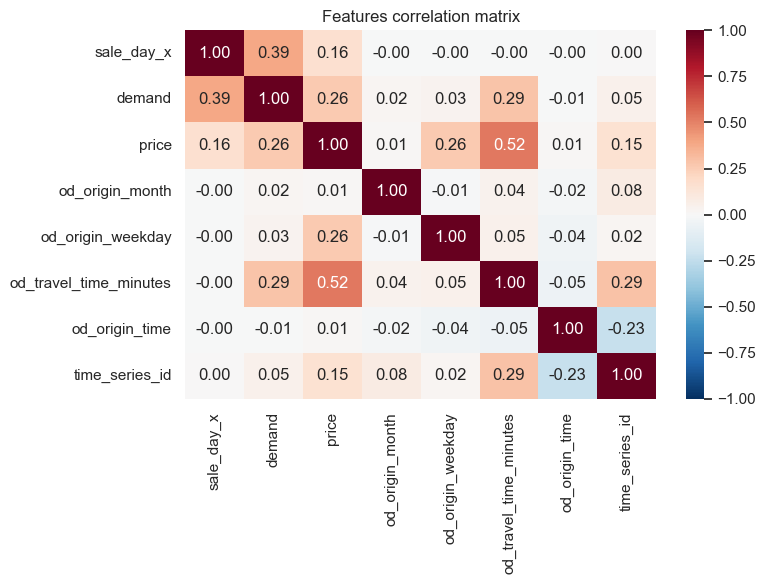

In [993]:
# Feature correlation matrix
numeric_cols = df.select_dtypes(include="number")
corr = numeric_cols.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="RdBu_r", vmin=-1, vmax=1)
plt.title("Features correlation matrix")
plt.tight_layout()
plt.show()




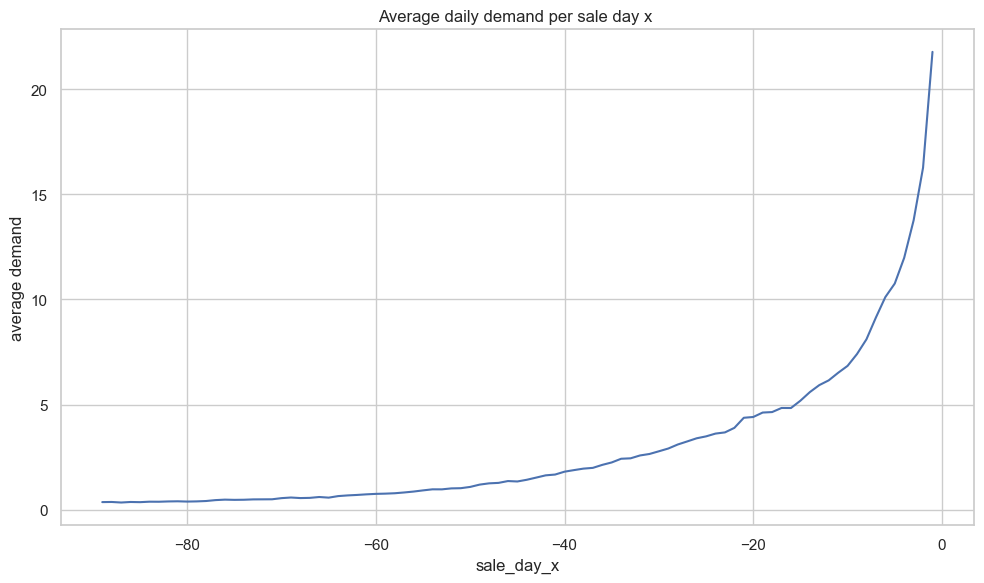

In [994]:
# Average daily demand per sale day
daily_mean = df.groupby("sale_day_x")['demand'].mean().sort_index()
plt.plot(daily_mean.index, daily_mean.values)
plt.title("Average daily demand per sale day x ")
plt.xlabel("sale_day_x")
plt.ylabel("average demand")
plt.tight_layout()
plt.show()


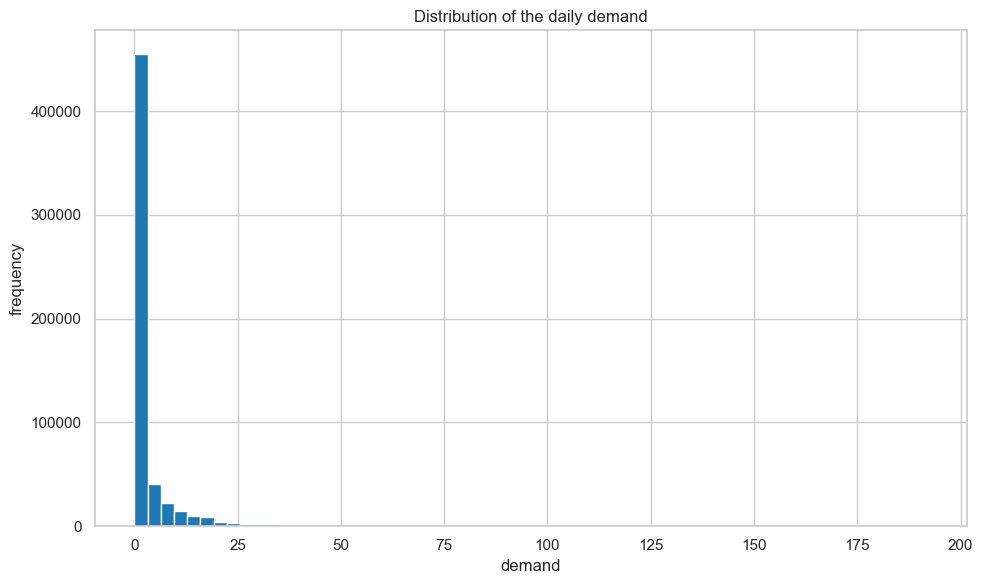

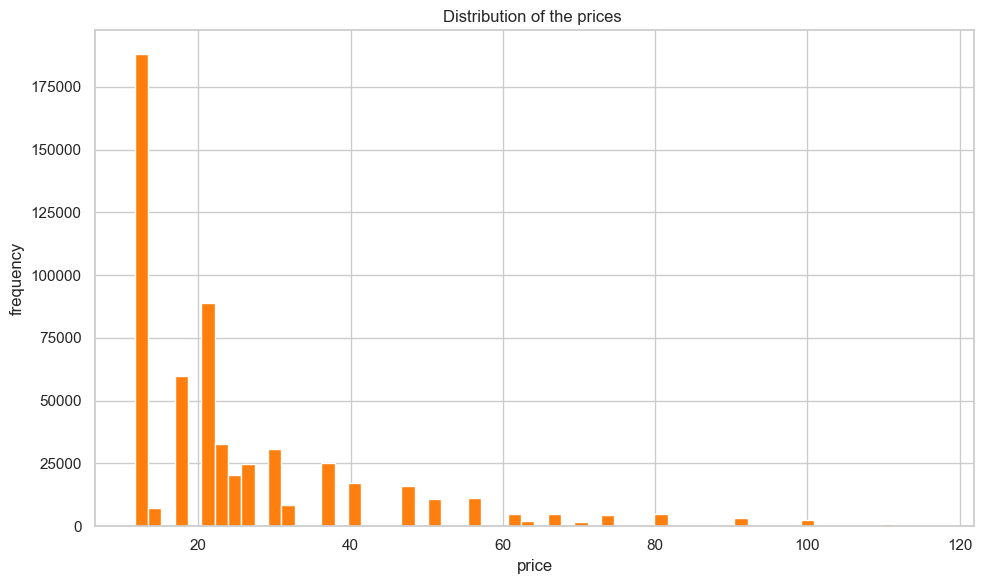

In [995]:
# Distribution of daily demand and prices
plt.hist(df["demand"], bins=60, color="#1f77b4", edgecolor="white")
plt.title("Distribution of the daily demand")
plt.xlabel("demand")
plt.ylabel("frequency")
plt.tight_layout()
plt.show()

plt.hist(df["price"], bins=60, color="#ff7f0e", edgecolor="white")
plt.title("Distribution of the prices ")
plt.xlabel("price")
plt.ylabel("frequency")
plt.tight_layout()
plt.show()



Demand and price are heavily right-skewed, that's why we will apply log(1+x) transformation to them. For the correlation, the demand is correlated with sale_day_x, price and od_travel_time_minutes. We will conserve those features and drop the rest.

In [996]:

df["demand"] = np.log10(1 + df["demand"])
df_test["demand"] = np.log10(1 + df_test["demand"])
df["price"] = np.log10(1 + df["price"])
df_test["price"] = np.log10(1 + df_test["price"])


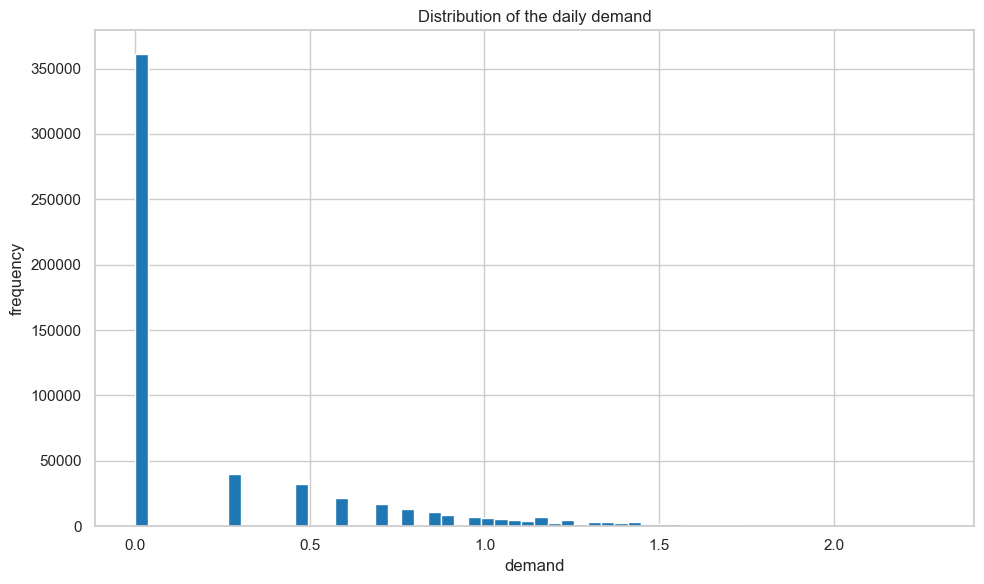

In [997]:
plt.hist(df["demand"], bins=60, color="#1f77b4", edgecolor="white")
plt.title("Distribution of the daily demand")
plt.xlabel("demand")
plt.ylabel("frequency")
plt.tight_layout()
plt.show()

In [998]:
df=df[['sale_day_x', 'demand', 'price',"time_series_id","od_travel_time_minutes"]]
df_test=df_test[['sale_day_x', 'demand', 'price',"time_series_id","od_travel_time_minutes"]]

In this project I decided to go with the LSTM architecture. To do that I decided to implement a preprocessing function that will encode categorical data like the stations name (This category is indeed dropped from the cell above but the one-hot encoding permits to use them if necessary).

I also added a sliding window to get the processed data. You can choose the size of the window as well as how many days you want to forecast (horizon) and the step which means how many cases will the window be sliding.

In [999]:
def preprocessing(df, window=20, horizon=1, step=1):
    df_num = df.select_dtypes(include="number")
    df_cat = df.select_dtypes(exclude="number")

    if df_cat.shape[1] > 0:
        encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
        cat_array = encoder.fit_transform(df_cat)
        cat_cols = encoder.get_feature_names_out(df_cat.columns)
        df_cat_encoded = pd.DataFrame(cat_array, columns=cat_cols, index=df_cat.index)
        df_encoded = pd.concat([df_num, df_cat_encoded], axis=1)
    else:
        df_encoded = df_num.copy()

    feature_cols = [c for c in df_encoded.columns if c not in {"demand", "time_series_id"}]

    X_segments = []
    y_segments = []

    for series_id, group in df_encoded.groupby(df["time_series_id"]):

        feature_values = torch.tensor(group[feature_cols].values, dtype=torch.float32)
        demand_values = torch.tensor(group["demand"].values, dtype=torch.float32)

        for start in range(0, len(group) - window - horizon + 1, step):
            end = start + window
            target_end = end + horizon
            X_segments.append(feature_values[start:end])
            y_segments.append(demand_values[end:target_end])

    X = torch.stack(X_segments)
    y = torch.stack(y_segments).unsqueeze(-1)

    return X, y

X_train, y_train = preprocessing(df)
X_test, y_test = preprocessing(df_test)


In [1000]:
print("X_test.shape",X_test.shape)
print("X_train.shape",X_train.shape)

X_test.shape torch.Size([25599, 20, 3])
X_train.shape torch.Size([443394, 20, 3])


Now it's time to implement the data loader. I made the TimeSeriesDataset which just satisfies the basic criteria of a dataset to put it in a data loader which is a len method and a getitem method.

In [1001]:
import math
from torch.utils.data import Dataset, DataLoader, random_split

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X.float()
        self.y = y.float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

full_train_ds = TimeSeriesDataset(X_train, y_train)
val_fraction = 0.1
val_size = max(1, int(len(full_train_ds) * val_fraction))
train_size = len(full_train_ds) - val_size
train_ds, val_ds = random_split(
    full_train_ds,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42),
)

test_ds = TimeSeriesDataset(X_test, y_test)

batch_size = 2000
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)


Now for the model I implemented a LSTM encoder-decoder:
The first LSTM (encoder) looks at your historical data and ends with an internal "summary" of what it learned.
The second LSTM (decoder) starts from that summary and generates the next several time steps.

Since demand is an integer, I also added a predict_int method for forecasting.
For the optimizer I chose Adam and for the loss I chose a classic MSE loss.

In [1002]:

class DemandForecaster(nn.Module):
    def __init__(self, input_dim, hidden_dim=32, num_layers=1, dropout=0.1, horizon=1):
        super().__init__()
        self.horizon = horizon
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=dropout ,
            batch_first=True,
        )
        self.decoder_lstm = nn.LSTM(
            input_size=1, 
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True,
        )
        self.head = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        _, (h_n, c_n) = self.lstm(x)
        decoder_input = torch.zeros(x.size(0), self.horizon, 1, device=x.device, dtype=x.dtype)
        decoder_output, _ = self.decoder_lstm(decoder_input, (h_n, c_n))
        preds = self.head(decoder_output)  # [batch, horizon, 1]
        return preds
    
    def predict_int(self, x):
        with torch.no_grad():
            preds_log = self.forward(x)  
            preds = torch.pow(10.0, preds_log) - 1.0
            return torch.clamp(torch.round(preds), min=0.0).long()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

horizon = y_train.shape[1]
model = DemandForecaster(input_dim=X_train.shape[2], horizon=horizon).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


In [1003]:
import torch



Now for the training which I implemented a classic training pipeline. I can only add that I used torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) which clips (limits) the size of your model's gradients during backprop so they don't explode.

In [1004]:
def run_epoch(model,loader, train=True):
    if train:
        model.train()
    else:
        model.eval()
    total_loss = 0.0
    total_mae = 0.0
    for X_batch, y_batch in loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        if train:
            optimizer.zero_grad()

        preds_log = model(X_batch) 
        preds_original = torch.pow(10.0, preds_log) - 1.0  
        y_batch_original = torch.pow(10.0, y_batch) - 1.0  
        loss = criterion(preds_original,y_batch_original)

        preds_int = torch.clamp(torch.round(preds_original), min=0.0)
        mae = torch.mean(torch.abs(preds_int - y_batch_original))

        if train:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

        total_loss += loss.item() * X_batch.size(0)
        total_mae += mae.item() * X_batch.size(0)

    total_loss /= len(loader.dataset)
    total_mae /= len(loader.dataset)
    return total_loss, total_mae

In [1005]:
num_epochs =15
best_val_loss = math.inf
for epoch in range(1, num_epochs + 1):
    train_loss, train_mae = run_epoch(model,train_loader, train=True)
    val_loss, val_mae = run_epoch(model,val_loader, train=False)

    print(
        f"Epoch {epoch:02d} | "
        f"train_loss={train_loss:.4f} train_mae={train_mae:.4f} | "
        f"val_loss={val_loss:.4f} val_mae={val_mae:.4f}"
    )

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_lstm_forecaster.pt")

Epoch 01 | train_loss=83.0214 train_mae=3.6470 | val_loss=80.7848 val_mae=3.5545
Epoch 02 | train_loss=61.8950 train_mae=3.3004 | val_loss=47.1549 val_mae=2.9623
Epoch 03 | train_loss=38.0956 train_mae=2.7834 | val_loss=37.0199 val_mae=2.7208
Epoch 04 | train_loss=33.8550 train_mae=2.6355 | val_loss=34.9495 val_mae=2.6452
Epoch 05 | train_loss=32.8440 train_mae=2.5903 | val_loss=34.4447 val_mae=2.5998
Epoch 06 | train_loss=32.4092 train_mae=2.5691 | val_loss=33.7238 val_mae=2.6056
Epoch 07 | train_loss=32.0314 train_mae=2.5546 | val_loss=33.5043 val_mae=2.5620
Epoch 08 | train_loss=31.8966 train_mae=2.5446 | val_loss=33.2553 val_mae=2.5592
Epoch 09 | train_loss=31.7511 train_mae=2.5384 | val_loss=33.0897 val_mae=2.5538
Epoch 10 | train_loss=31.6385 train_mae=2.5330 | val_loss=32.9727 val_mae=2.5529
Epoch 11 | train_loss=31.5531 train_mae=2.5287 | val_loss=32.8322 val_mae=2.5615
Epoch 12 | train_loss=31.4809 train_mae=2.5265 | val_loss=32.8321 val_mae=2.5754
Epoch 13 | train_loss=31.452

In [1007]:
model.load_state_dict(torch.load("best_lstm_forecaster.pt", map_location=device))
test_loss, test_mae = run_epoch(model,test_loader, train=False)
print(f"Test loss={test_loss:.4f} test MAE={test_mae:.4f}")


Test loss=43.5825 test MAE=3.1807


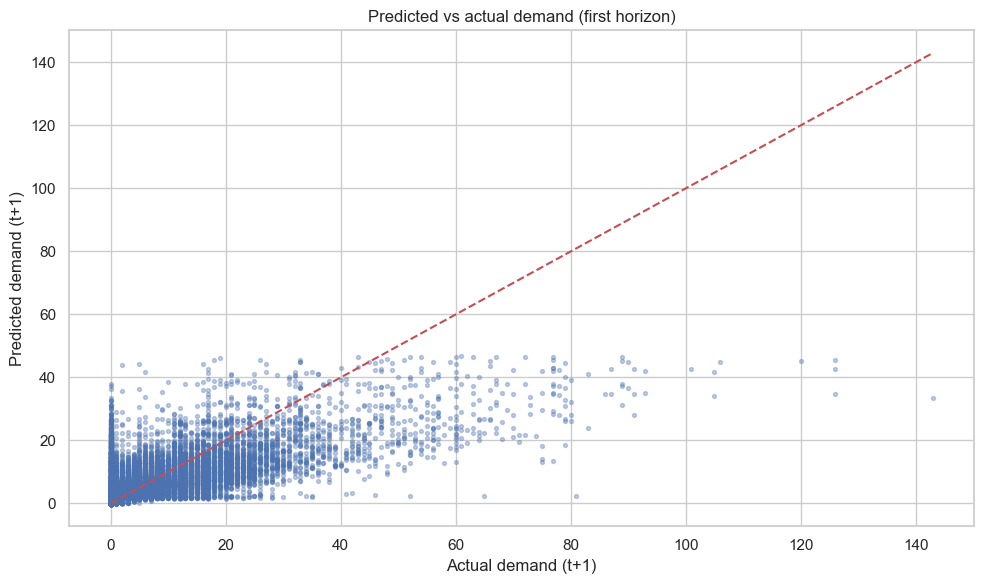

In [1009]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test)

y_true_np = np.power(10.0, y_test.squeeze(-1).cpu().numpy()) - 1.0  
y_pred_np = np.power(10.0, y_pred.squeeze(-1).cpu().numpy()) - 1.0

actual = y_true_np[:, 0]
predicted = y_pred_np[:, 0]

plt.scatter(actual, predicted, s=8, alpha=0.35)
lims = [min(actual.min(), predicted.min()), max(actual.max(), predicted.max())]
plt.plot(lims, lims, 'r--')
plt.xlabel('Actual demand (t+1)')
plt.ylabel('Predicted demand (t+1)')
plt.title('Predicted vs actual demand (first horizon)')
plt.tight_layout()
plt.show()


We see in this diagram that the prediction doesn't follow the prediction line which is very bad. The problem here is that the majority of the demand is 0. A naive model forecasting only 0 will still hit a good performance. That's why we will change the loss function and penalize the points closer to 0. My idea was to use a weighted MSE that I implemented and do the training.

In [1014]:
def weighted_mse_nonzero(y_pred, y, weight_pos=5.0, eps=1):

    base = (y_pred - y) ** 2
    mask = (y.abs() > eps).float()
    w = 1.0 + (weight_pos - 1.0) * mask
    loss = base * w
    return loss.sum()


In [1015]:
criterion=lambda x, y :weighted_mse_nonzero(x,y)

In [1016]:
model2 = DemandForecaster(input_dim=X_train.shape[2], horizon=horizon).to(device)
optimizer = torch.optim.Adam(model2.parameters(), lr=1e-4)

In [1017]:
num_epochs =15
best_val_loss = math.inf
for epoch in range(1, num_epochs + 1):
    train_loss, train_mae = run_epoch(model2,train_loader, train=True)
    val_loss, val_mae = run_epoch(model2,val_loader, train=False)

    print(
        f"Epoch {epoch:02d} | "
        f"train_loss={train_loss:.4f} train_mae={train_mae:.4f} | "
        f"val_loss={val_loss:.4f} val_mae={val_mae:.4f}"
    )

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model2.state_dict(), "best_lstm_forecaster2.pt")

Epoch 01 | train_loss=567809.9178 train_mae=3.3490 | val_loss=392962.7913 val_mae=3.4131
Epoch 02 | train_loss=326742.9977 train_mae=3.2792 | val_loss=327369.9425 val_mae=3.2298
Epoch 03 | train_loss=283628.8479 train_mae=3.1489 | val_loss=287994.5025 val_mae=3.1857
Epoch 04 | train_loss=266353.2511 train_mae=3.0862 | val_loss=280827.7782 val_mae=3.0789
Epoch 05 | train_loss=260722.6978 train_mae=3.0537 | val_loss=274034.0788 val_mae=3.0644
Epoch 06 | train_loss=257084.7008 train_mae=3.0099 | val_loss=270565.2284 val_mae=3.0567
Epoch 07 | train_loss=254849.2566 train_mae=2.9706 | val_loss=268529.9975 val_mae=2.9731
Epoch 08 | train_loss=253023.0068 train_mae=2.9404 | val_loss=265817.9785 val_mae=2.9372
Epoch 09 | train_loss=251187.9204 train_mae=2.9307 | val_loss=264780.2341 val_mae=2.9634
Epoch 10 | train_loss=250115.2217 train_mae=2.9258 | val_loss=264293.5443 val_mae=2.9082
Epoch 11 | train_loss=248441.2892 train_mae=2.9161 | val_loss=261473.1855 val_mae=2.9380
Epoch 12 | train_loss

In [1018]:
model2.load_state_dict(torch.load("best_lstm_forecaster.pt", map_location=device))
test_loss, test_mae = run_epoch(model2,test_loader, train=False)
print(f"Test loss={test_loss:.4f} test MAE={test_mae:.4f}")

Test loss=355250.0532 test MAE=3.1807


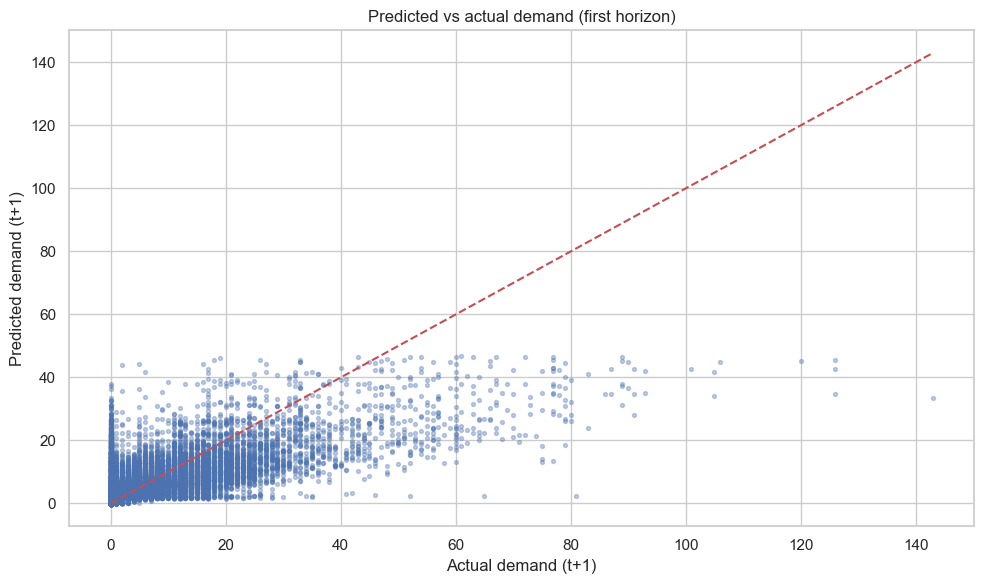

In [1019]:
# Evaluation plots for first horizon step
import numpy as np

model2.eval()
with torch.no_grad():
    y_pred = model2(X_test)

y_true_np = np.power(10.0, y_test.squeeze(-1).cpu().numpy()) - 1.0  
y_pred_np = np.power(10.0, y_pred.squeeze(-1).cpu().numpy()) - 1.0

actual = y_true_np[:, 0]
predicted = y_pred_np[:, 0]

plt.scatter(actual, predicted, s=8, alpha=0.35)
lims = [min(actual.min(), predicted.min()), max(actual.max(), predicted.max())]
plt.plot(lims, lims, 'r--')
plt.xlabel('Actual demand (t+1)')
plt.ylabel('Predicted demand (t+1)')
plt.title('Predicted vs actual demand (first horizon)')
plt.tight_layout()
plt.show()




Unfortunately, this approach didn’t work.